In [ ]:
# DS-1 Weather Forecasting Pipeline

# Step 1: Data Collection from OpenWeatherMap API
import requests
import pandas as pd
from datetime import datetime

API_KEY = "f2b6527500ebd13d7c2db06eee2c7654"
CITY = "Mumbai"
URL = f"http://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={API_KEY}&units=metric"


response = requests.get(URL)
data = response.json()

weather_data = []
for item in data['list']:
    weather_data.append({
        'date_time': datetime.utcfromtimestamp(item['dt']),
        'temperature': item['main']['temp'],
        'humidity': item['main']['humidity'],
        'pressure': item['main']['pressure'],
        'wind_speed': item['wind']['speed'],
        'wind_direction': item['wind'].get('deg', 0),
        'cloud_coverage': item['clouds']['all'],
        'precipitation': item.get('rain', {}).get('3h', 0)  # or 'snow'
    })

# Step 2: Preprocessing
weather_df = pd.DataFrame(weather_data)
weather_df = weather_df.fillna(method='ffill')
weather_df.to_csv("weather_data.csv", index=False)

# Step 3: ML Model Training (Random Forest)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = weather_df.drop(['temperature', 'date_time'], axis=1)
y = weather_df['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, predictions))

# Step 4: Save Predictions
forecast_df = weather_df.copy()
forecast_df['predicted_temperature'] = model.predict(X)
forecast_df[['date_time', 'predicted_temperature']].to_csv("forecast.csv", index=False)

<ipython-input-1-935cc29162e7>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df = weather_df.fillna(method='ffill')


MAE: 0.42529999999999335


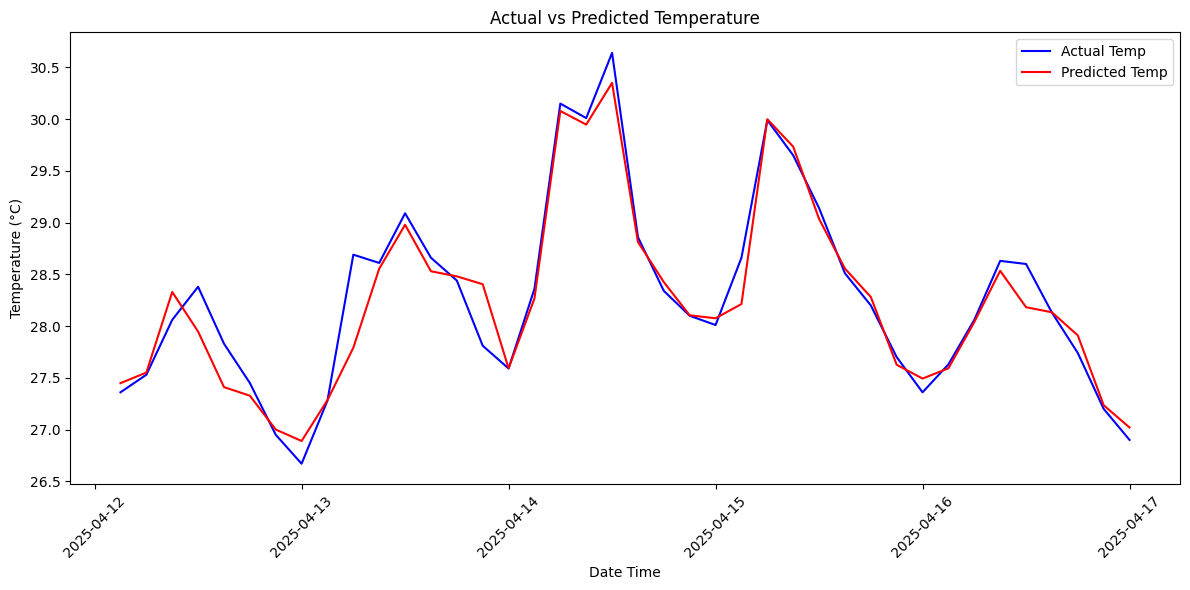

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(forecast_df['date_time'], forecast_df['temperature'], label='Actual Temp', color='blue')
plt.plot(forecast_df['date_time'], forecast_df['predicted_temperature'], label='Predicted Temp', color='red')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


INSTALL REQUIRED PACKAGES FOR Dashboard

In [ ]:
!pip install ipywidgets voila --quiet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00


PREPARE DATA FOR DASHBOARD

In [ ]:
# Ensure date_time column is datetime type
forecast_df['date_time'] = pd.to_datetime(forecast_df['date_time'])
weather_df['date_time'] = pd.to_datetime(weather_df['date_time'])

# Sync actual temperature (in case of refresh)
forecast_df['temperature'] = weather_df['temperature']


PREDICTION EXPLORER-SLIDER TO VIEW FORECASTS

In [ ]:
# Create row slider
row_slider = widgets.IntSlider(
    min=0,
    max=len(forecast_df)-1,
    step=1,
    value=len(forecast_df)-1,
    description='Index:',
    continuous_update=False
)

# Function to display data
def display_prediction(row):
    data_point = forecast_df.iloc[row]
    print(f"📅 Date/Time: {data_point['date_time']}")
    print(f"🌡️ Actual Temp: {data_point['temperature']} °C")
    print(f"🔮 Predicted Temp: {data_point['predicted_temperature']:.2f} °C")
    display(widgets.HTML("<h3>📈 Forecast Explorer</h3>"))

# Display widget
widgets.interact(display_prediction, row=row_slider)


interactive(children=(IntSlider(value=39, continuous_update=False, description='Index:', max=39), Output()), _…

<function __main__.display_prediction(row)>

FUTURE TREND VISUALIZER

In [ ]:
# Feature selector
available_features = [col for col in weather_df.columns if col not in ['date_time', 'temperature']]
feature_toggle = widgets.SelectMultiple(
    options=available_features,
    value=[available_features[0]],
    description='Features:',
    disabled=False
)

# Plot trends
def plot_features(features):
    plt.figure(figsize=(14,6))
    for feature in features:
        plt.plot(weather_df['date_time'], weather_df[feature], label=feature)
    plt.xlabel('Date Time')
    plt.ylabel('Value')
    plt.title('📊 Weather Feature Trends')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_features, features=feature_toggle)


interactive(children=(SelectMultiple(description='Features:', index=(0,), options=('humidity', 'pressure', 'wi…

<function __main__.plot_features(features)>